## Tutorial de Classificação Neural do banco de dados Iris

Autor: Natanael Junior (natmourajr@gmail.com)

Laboratorio de Processamento de Sinais - UFRJ

In [1]:
%time
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import np_utils
from sklearn import datasets
from sklearn import cross_validation
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


Using Theano backend.


In [2]:
%time
# import some data to play with
iris = datasets.load_iris()
data = iris.data # iris data
trgt = iris.target # iris data
iris_colors = ['b','r','g']
iris_labels = ['Setosa','Versicolor','Virginica']

# for classification -> target max sparse
trgt_sparse = np_utils.to_categorical(trgt)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [3]:
%time

# train a simple classifier

n_folds = 3
n_inits = 3
norm = 'mapstd'

CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)

classifiers = {}
for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    
    # normalize data based in train set
    if norm == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(data[train_id,:])
    elif norm == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(data[train_id,:])
    elif norm == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
    norm_data = scaler.transform(data)
   
    best_init = 0
    best_loss = 999
    
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i --- Init %i of %i'%(
                ifold+1, n_folds, 
                i_init+1, n_inits))
        model = Sequential()
        model.add(Dense(data.shape[1],
                        input_dim=data.shape[1],
                        init='identity',
                        trainable=False))
        model.add(Activation('linear'))
        model.add(Dense(10, input_dim=data.shape[1], 
                        init='uniform'))
        model.add(Activation('tanh'))
        model.add(Dense(trgt_sparse.shape[1],
                        init='uniform')) 
        model.add(Activation('tanh'))
        
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.7)
        model.compile(loss='mean_squared_error',
                      optimizer=sgd,
                      metrics=['accuracy'])
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=25, 
                                                verbose=0, 
                                                mode='auto')
        # Train model
        init_trn_desc = model.fit(data[train_id], 
                                  trgt_sparse[train_id], 
                                  nb_epoch=100, 
                                  batch_size=9, 
                                  callbacks=[earlyStopping], 
                                  verbose=0, 
                                  validation_data=(data[test_id],
                                                   trgt_sparse[test_id]), 
                                  shuffle=True)
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            classifiers[ifold] = model

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs
Processing: Fold 1 of 3 --- Init 1 of 3
Processing: Fold 1 of 3 --- Init 2 of 3
Processing: Fold 1 of 3 --- Init 3 of 3
Processing: Fold 2 of 3 --- Init 1 of 3
Processing: Fold 2 of 3 --- Init 2 of 3
Processing: Fold 2 of 3 --- Init 3 of 3
Processing: Fold 3 of 3 --- Init 1 of 3
Processing: Fold 3 of 3 --- Init 2 of 3
Processing: Fold 3 of 3 --- Init 3 of 3


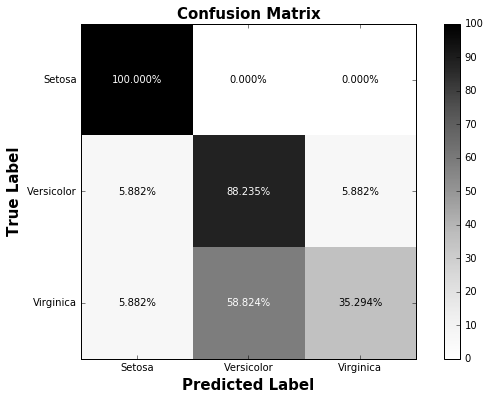

In [4]:
# analyse train process - confusion matrix
from sklearn.metrics import confusion_matrix

choose_fold = 1

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
output_class = np.argmax(output,axis=1)

cm = confusion_matrix(trgt[test_id], output_class[test_id])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape

for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(iris_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(iris_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(iris_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)

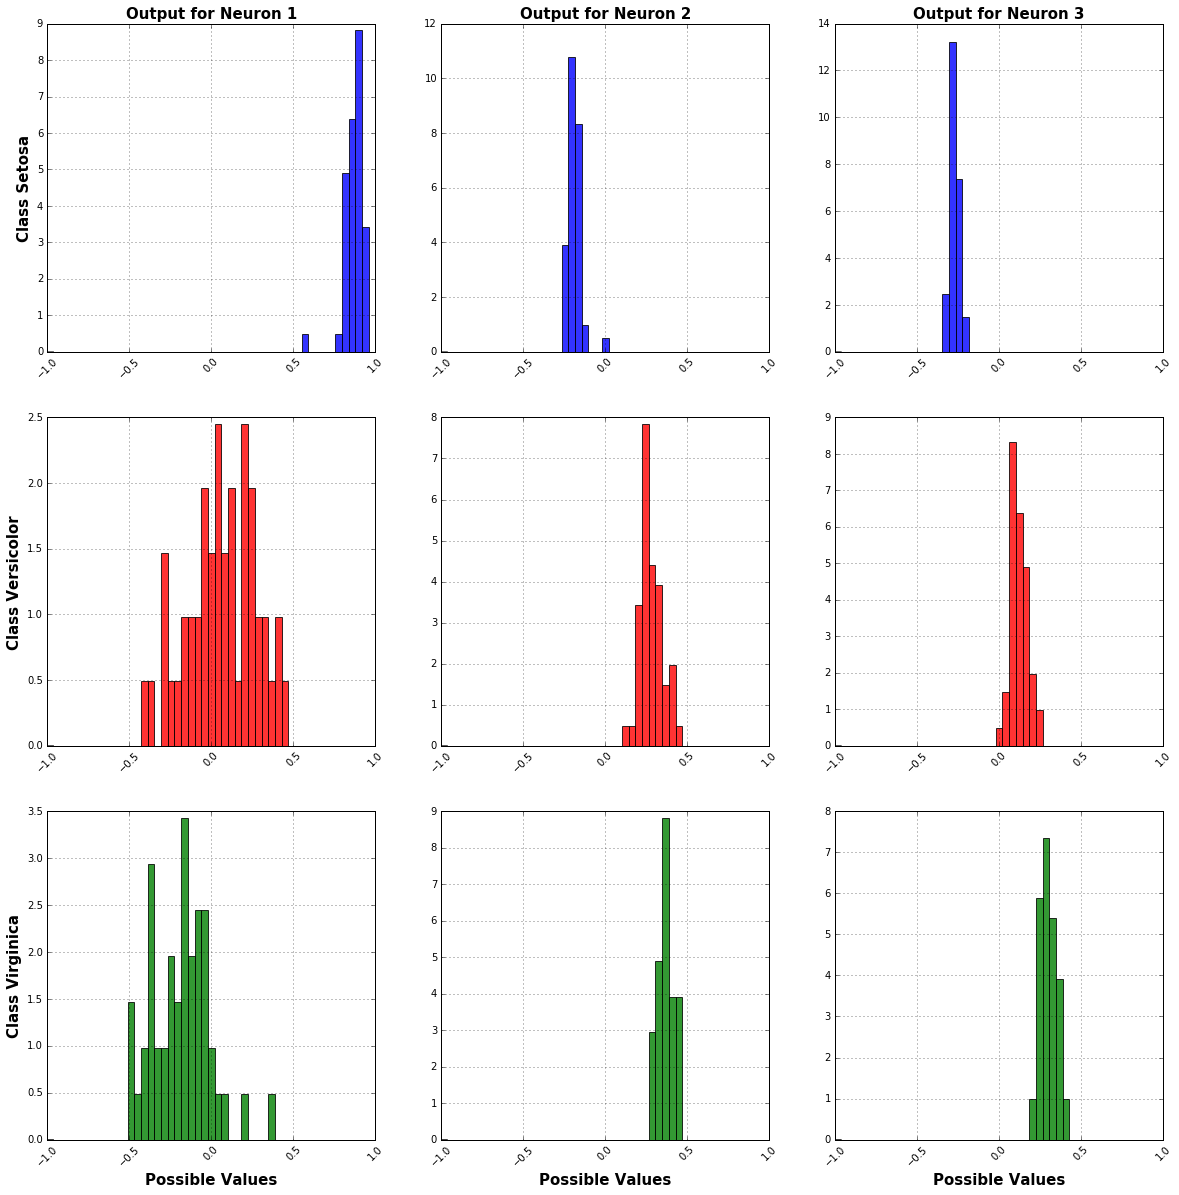

In [5]:
# analyse train process - output distribution
from sklearn.metrics import confusion_matrix

choose_fold = 0

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
output_class = np.argmax(output,axis=1)

n_rows = trgt_sparse.shape[1]
n_columns = output.shape[1]

fig, ax = plt.subplots(figsize=(20,20),nrows=n_rows, ncols=n_columns)
m_bins = np.linspace(-1., 1., 50)


irow = 0
icolumn = 0
for itarget in range(trgt_sparse.shape[1]):
    for ioutput in range(output.shape[1]):
        m_pts = output[trgt==itarget,ioutput]
        n, bins, patches = (ax[irow,icolumn].hist(m_pts,bins=m_bins,
                                                      fc=iris_colors[itarget],
                                                      alpha=0.8, normed=1))
        for tick in ax[irow,icolumn].get_xticklabels():
            tick.set_rotation(45)
        ax[irow,icolumn].grid()
    
        if irow == 0:
            ax[irow,icolumn].set_title('Output for Neuron %i'%(ioutput+1),
                                       fontweight='bold',fontsize=15)
        if icolumn == 0:
            ax[irow,icolumn].set_ylabel('Class %s'%(iris_labels[itarget]),
                                        fontweight='bold',fontsize=15)
        if irow == n_rows-1:
            ax[irow,icolumn].set_xlabel('Possible Values',
                                        fontweight='bold',fontsize=15)
    
        
        if icolumn+1 == n_columns:
            icolumn = 0
            irow = irow+1
        else:
            icolumn = icolumn+1